In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv("features.csv", index_col="match_id")
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
train.drop(["duration","tower_status_radiant","tower_status_dire",
    "barracks_status_radiant","barracks_status_dire",], axis=1, inplace=True)

In [4]:
emp = len(train) - train.count()
emp[emp > 0].sort_values(ascending=False) / len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

1)first_blood_player2 fb, совершенное одним игроком часто встречается (45%)
2)radiant_flying_courier_time также довольно часто команда не покупает курьера в первые 5 минут (28%)

In [5]:
train.fillna(0, inplace=True)

In [6]:
X_train = train.drop("radiant_win", axis=1)
y_train = train["radiant_win"] ##целевая переменная

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
import datetime

def score_gb(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for n in [10, 20, 30, 50, 100, 250]:
        print(f"n={n}")
        model = GradientBoostingClassifier(n_estimators=n, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.2f}")
        print(f"Operating time: {datetime.datetime.now() - start_time}")

        scores[n] = score
        print()
        
    return pd.Series(scores)

n=10
Score: 0.66
Operating time: 0:00:06.551014

n=20
Score: 0.68
Operating time: 0:00:10.619994

n=30
Score: 0.69
Operating time: 0:00:15.175168

n=50
Score: 0.70
Operating time: 0:00:24.814202

n=100
Score: 0.71
Operating time: 0:00:49.020420

n=250
Score: 0.72
Operating time: 0:02:04.589739



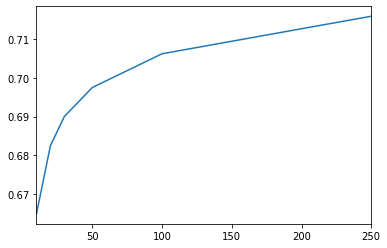

In [10]:
scores = score_gb(X_train, y_train)
scores.plot()

Время работы классификатора вы можете увидеть выше. По графику видно, что качество будет расти при дальнейшем увеличении n.

Логическая регрессия

In [11]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

def score_lr(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for i in range(-5, 6):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[i] = score
        print()

    return pd.Series(scores)

C=1e-05
Score: 0.695
Time elapsed: 0:00:01.194906

C=0.0001
Score: 0.711
Time elapsed: 0:00:01.894268

C=0.001
Score: 0.716
Time elapsed: 0:00:03.298097

C=0.01
Score: 0.717
Time elapsed: 0:00:04.137955

C=0.1
Score: 0.717
Time elapsed: 0:00:04.545159

C=1.0
Score: 0.717
Time elapsed: 0:00:04.613077

C=10.0
Score: 0.717
Time elapsed: 0:00:04.633309

C=100.0
Score: 0.717
Time elapsed: 0:00:04.614612

C=1000.0
Score: 0.717
Time elapsed: 0:00:04.782491

C=10000.0
Score: 0.717
Time elapsed: 0:00:05.136525

C=100000.0
Score: 0.717
Time elapsed: 0:00:05.197581



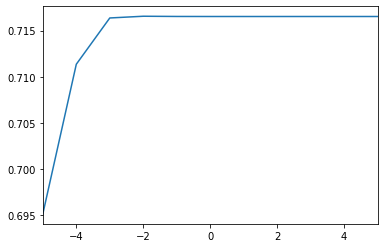

In [12]:
scores = score_lr(X_train, y_train)
scores.plot()

In [13]:
def print_(scores: pd.Series):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = 10.0 ** best_iteration.index[0]
    best_score = best_iteration.values[0]

    print(f"C = {best_C:.2f} Score={best_score:.2f}.")

In [14]:
print_(scores)

C = 0.01 Score=0.72.


Качество почти такое же как при n=250. в градиентном бустинге, но логистическая регрессия работает намного быстрее.
Можем предположить, что зависимость между признаками и целевой переменной линейный, тк разница с градиентным бустингом незначительна.

In [15]:
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
cat_columns = ["lobby_type"] + hero_columns
X_train.drop(cat_columns, axis=1, inplace=True)

C=1e-05
Score: 0.695
Time elapsed: 0:00:01.657682

C=0.0001
Score: 0.711
Time elapsed: 0:00:02.092067

C=0.001
Score: 0.716
Time elapsed: 0:00:02.677321

C=0.01
Score: 0.717
Time elapsed: 0:00:03.536179

C=0.1
Score: 0.717
Time elapsed: 0:00:03.748404

C=1.0
Score: 0.717
Time elapsed: 0:00:04.128731

C=10.0
Score: 0.717
Time elapsed: 0:00:04.136670

C=100.0
Score: 0.717
Time elapsed: 0:00:03.750851

C=1000.0
Score: 0.717
Time elapsed: 0:00:03.839388

C=10000.0
Score: 0.717
Time elapsed: 0:00:04.054288

C=100000.0
Score: 0.717
Time elapsed: 0:00:05.505633



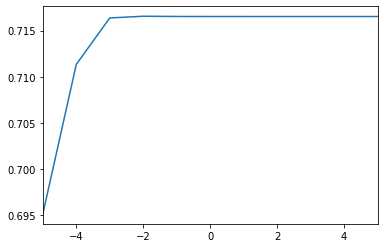

In [16]:
scores = score_lr(X_train, y_train)
scores.plot()

In [17]:
print_(scores)

C = 0.01 Score=0.72.


Видим, что ничего не изменилось, следовательно, ранее эти признаки никак не влияли на результат.

In [18]:
unique_heroes = np.unique(train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Кол-во уникальных героев: {len(unique_heroes)}. Максимальный id: {N}.")

Кол-во уникальных героев: 108. Максимальный id: 112.


In [20]:
def get_pick(data: pd.DataFrame) -> pd.DataFrame:
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])

X_pick = get_pick(train)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_train = pd.concat([X_train, X_pick], axis=1)

C=1e-05
Score: 0.699
Time elapsed: 0:00:03.715890

C=0.0001
Score: 0.725
Time elapsed: 0:00:02.673136

C=0.001
Score: 0.746
Time elapsed: 0:00:04.775335

C=0.01
Score: 0.752
Time elapsed: 0:00:07.086644

C=0.1
Score: 0.752
Time elapsed: 0:00:09.324499

C=1.0
Score: 0.752
Time elapsed: 0:00:09.201667

C=10.0
Score: 0.752
Time elapsed: 0:00:09.290919

C=100.0
Score: 0.752
Time elapsed: 0:00:09.289143

C=1000.0
Score: 0.752
Time elapsed: 0:00:09.211896

C=10000.0
Score: 0.752
Time elapsed: 0:00:09.187622

C=100000.0
Score: 0.752
Time elapsed: 0:00:09.265260



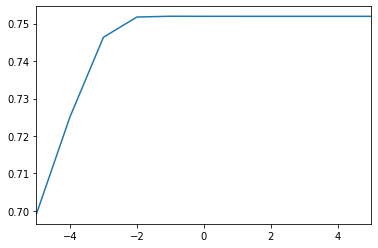

In [22]:
scores = score_lr(X_train, y_train)
scores.plot()

In [23]:
print_(scores)

C = 0.10 Score=0.75.


Качество улучшилось, тк мы заметно уменьшили шум и теперь нет пустых данных.

In [24]:
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
test = pd.read_csv("data/features_test.csv", index_col="match_id")
test.fillna(0, inplace=True)

In [26]:
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
X_test.drop(cat_columns, axis=1, inplace=True)
X_test = pd.concat([X_test, get_pick(test)], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
preds = pd.Series(model.predict_proba(X_test)[:, 1])
preds.describe()

count    17177.000000
mean         0.517025
std          0.220954
min          0.008429
25%          0.346069
50%          0.522147
75%          0.691689
max          0.996371
dtype: float64

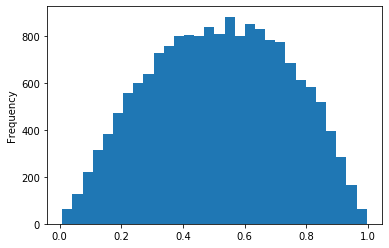

In [28]:
preds.plot.hist(bins=30)